# Restuarants Recommender System using Matrix Factorization


#### Matrix Factorization uses two entities to generate latent features. It identifies the relationship between items and users' entities. With users ratings and reviews,  restaurants can be recommended to the new user based on their preferences using the concept of content and collaborative filtering.

## Import library and load dataset

In [1]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [82]:
!pip install plotly_express
!pip install folium 

In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords 
from nltk.tokenize import WordPunctTokenizer
import string
from sklearn.metrics import accuracy_score,mean_squared_error

In [69]:
import seaborn as sns
import plotly 
import plotly.offline as py
import plotly.graph_objs as go
import plotly_express as px
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [63]:
df = pd.read_pickle("/content/drive/MyDrive/austin_raunts_reviews_v2.pkl")
df_business = pd.read_pickle('/content/drive/MyDrive/austin_just_raunts.pkl')

In [64]:
df.head(3)

,business_id,name,address,city,state,postal_code,latitude,longitude,review_count,is_open,attributes,categories,hours,review_id,user_id,review_stars,useful,funny,cool,text,date,user_avg,user_name,user_review_count,friends,useful_reviews,business_avg
0,Xw8tuI30T-xihpzwBV-zJg,El Pollo Rey,1725 E Riverside Dr,Austin,TX,78741,30.243493,-97.730141,11,0,"{'RestaurantsGoodForGroups': 'True', 'Restaura...","Food Trucks, Restaurants, Specialty Food, Food...",None,iFlV31O6OIXQr-ylsWd9Og,osDHoCmrFeCnj9dZ8AAwtQ,5,0,0,0,I don't like the closeness to the road or the ...,2015-11-06 00:32:16,4.11,Austin,9,None,7,5.0
1,Xw8tuI30T-xihpzwBV-zJg,El Pollo Rey,1725 E Riverside Dr,Austin,TX,78741,30.243493,-97.730141,11,0,"{'RestaurantsGoodForGroups': 'True', 'Restaura...","Food Trucks, Restaurants, Specialty Food, Food...",None,7skMplBYqKs2mNC0Mqqubw,zOrmCZPeuHRnQ6oY2Qtehg,4,0,0,0,Pretty solid food truck. I tried the Chicken T...,2014-09-11 00:45:20,4.67,Ryan,14,"FKhmgrCMfB-n4MpMJiSAJw, M6mXEI3kUxRfYz3FjG7GaA...",6,5.0
2,Xw8tuI30T-xihpzwBV-zJg,El Pollo Rey,1725 E Riverside Dr,Austin,TX,78741,30.243493,-97.730141,11,0,"{'RestaurantsGoodForGroups': 'True', 'Restaura...","Food Trucks, Restaurants, Specialty Food, Food...",None,Zf9wXDxxlf6FW0esiiAmrg,kb7-Yvk_VY-H5Zh-QQMgcA,4,2,0,1,This is another trailer within about a mile of...,2013-02-01 01:45:16,3.43,Macklin,6,"_DszxpFFKyvvMlAOJRiGtQ, DsBWvMNXtRVKhOt_aZRLfA...",15,5.0


## Top 10 resturants by categories

In [7]:
#Top 10 restuarants by categories
df_top = df[["categories"]].value_counts()[:10]
print(df_top)

categories                                                                                                                                                         
Mexican, Restaurants                                                                                                                                                   8811
Restaurants, Mexican                                                                                                                                                   7628
Local Flavor, Salad, Sandwiches, Restaurants, Barbeque, Food, Food Stands                                                                                              5071
Venues & Event Spaces, American (Traditional), Southern, Restaurants, American (New), Cocktail Bars, Nightlife, Event Planning & Services, Bars, Breakfast & Brunch    4901
American (New), American (Traditional), Restaurants, Burgers                                                                                        

### Filter irrelevant data(Non restuarant's related)

In [8]:
# There are lots of irrelevant categories that we need to get rid of.
df_food = df['categories'].str.contains('Food|Restuarants|Barbeque|Mexican|American',regex = True)
df_filtered = df[df_food]
print("Before filter :" + str(df["categories"].count()))
print("After filter : " +  str(df_filtered["categories"].count()))

Before filter :916762
After filter : 684219


**Dropped categories**

In [14]:
# The categories dropped. We don't need them
categories_dropped = ['Grocery','Drugstores','Convenience Stores','Beauty & Spas','Photography Stores & Services','Cosmetics & Beauty Supply','Discount Store','Fashion','Department Stores','Gas Stations',
                      'Automotive','Music & Video','Event Planning & Services','Mobile Phones','Health & Medical','Weight Loss Centers','Home & Garden','Kitchen & Bath','Jewelry',"Children's Clothing",
                      'Accessories','Home Decor','Bus Tours','Auto Glass Services','Auto Detailing','Oil Change Stations', 'Auto Repair','Body Shops','Car Window Tinting','Car Wash',
                      'Gluten-Free','Fitness & Instruction','Nurseries & Gardening','Wedding Planning','Embroidery & Crochet','Dance Schools','Performing Arts','Wholesale Stores','Tobacco Shops','Nutritionists','Hobby Shops','Pet Services',
                      'Electronics','Plumbing','Gyms','Yoga','Walking Tours','Toy Stores','Pet Stores',
                      'Pet Groomers','Vape Shops','Head Shops','Souvenir Shops','Pharmacy','Appliances & Repair','Wholesalers','Party Equipment Rentals',
                      'Tattoo','Funeral Services & Cemeteries','Sporting Goods','Dog Walkers','Pet Boarding/Pet Sitting','Scavenger Hunts','Contractors','Trainers', 
                      'Customized Merchandise', 'Dry Cleaning & Laundry', 'Art Galleries''Tax Law', 'Bankruptcy Law', 'Tax Services', 'Estate Planning Law', 
                      'Business Consulting', 'Lawyers', 'Pet Adoption', 'Escape Games', 
                      'Animal Shelters', 'Commercial Real Estate', 'Real Estate Agents', 'Real Estate Services', 'Home Inspectors']

In [15]:
#df_train_new.tail()

# Perform EDA

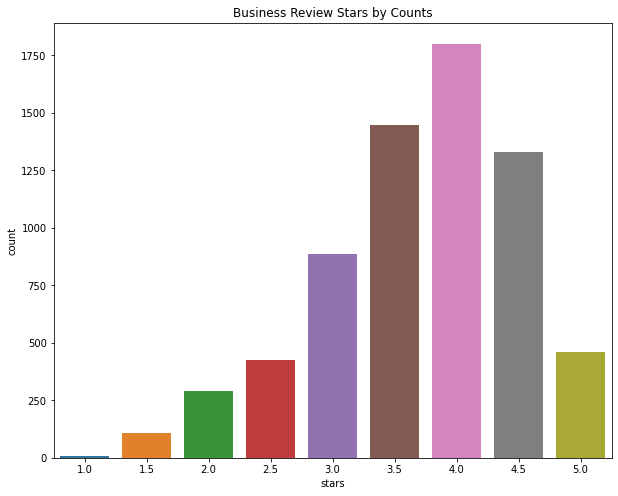

In [65]:
# Let's look at the restuarant reviews stars by counts
fig, ax = plt.subplots(figsize=(10,8))
sns.countplot(raunts['stars'], ax=ax)
plt.title('Business Review Stars by Counts')
plt.savefig('stars.png')
plt.show()

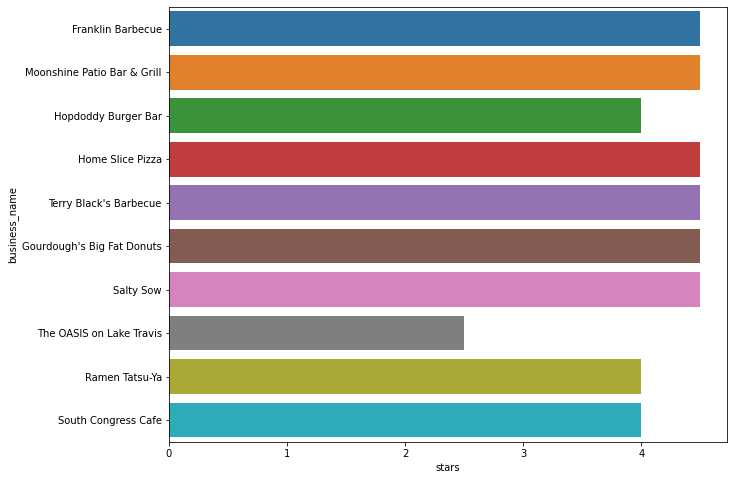

In [60]:
# Checking out top 10 restuarants by review in Austin
top_restaurants_by_reviews = raunts.sort_values(by=["review_counts", "stars"], ascending=False)[:10]
fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(x = 'stars', y = "business_name", data=top_restaurants_by_reviews, ax= ax);
plt.savefig('top10_restaurants.png')
plt.show()

# Location-Based Recommendation.
In order to made our product very robust, we included an option for recommendation based upon closest location. This utilizes longitude and latitude and user preference to recommend ten best restuarants. Hence we included clusters using K-Means and elbow method to find the best ```k```

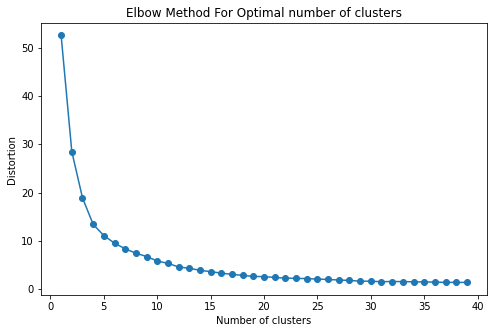

In [91]:
# calculate distortion for a range of number of cluster
location = df_business[["business_latitude","business_longitude"]]
distortions = []
for k in range(1, 40):
    kmeans = KMeans(n_clusters=k, init='random',n_init=10, max_iter=300,tol=1e-04, random_state=0)
    kmeans.fit(location)
    distortions.append(kmeans.inertia_)

# plotting
fig = plt.gcf()
fig.set_size_inches(8, 5)
plt.plot(range(1, 40), distortions, marker='o')
plt.title('Elbow Method For Optimal number of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.savefig('KmeansElbow.png',dpi = 100)
plt.show()

In [116]:
# From the elbow method above, It looks to me like the optimum k is at 4.
#Let's evaluate using most common Kmeans metric 
kmeans = KMeans(n_clusters=4, init='k-means++')
kmeans.fit(location)
print("silhouette_score : {}".format(silhouette_score(location, kmeans.labels_, metric='euclidean')))

silhouette_score : 0.5023429807633483


In [117]:
#Time to add a new feature to our dataset
df_business['cluster'] = kmeans.predict(df_business[["business_latitude","business_longitude"]])
df_business.head(3)

,business_id,business_name,business_address,business_city,business_state,business_latitude,business_longitude,stars,review_counts,is_open,categories,attributes,BusinessParking,Ambience,GoodForMeal,Dietary,Music,cluster
38,Xw8tuI30T-xihpzwBV-zJg,El Pollo Rey,1725 E Riverside Dr,Austin,TX,30.243493,-97.730141,5.0,11,0,"Food Trucks, Restaurants, Specialty Food, Food...","{'RestaurantsGoodForGroups': 'True', 'Restaura...","{'garage': False, 'street': False, 'validated'...","{'romantic': False, 'intimate': False, 'classy...",{},{},{},1
41,NRPemqVb4qpWFF0Avq_6OQ,Eurasia Sushi Bar & Seafood,"7101 W Hwy 71, Ste C-13",Austin,TX,30.234533,-97.877262,4.5,395,1,"Bars, Nightlife, Cocktail Bars, Seafood, Resta...","{'CoatCheck': 'False', 'GoodForDancing': 'Fals...","{'garage': False, 'street': False, 'validated'...","{'touristy': False, 'hipster': False, 'romanti...","{'dessert': None, 'latenight': False, 'lunch':...",{},"{'dj': False, 'background_music': False, 'no_m...",2
61,bRsDZ44CD3uhGnRY3NeQhQ,Wendy's,6247 Mcneil Drive,Austin,TX,30.441875,-97.746581,2.0,46,1,"Fast Food, Restaurants, Burgers","{'RestaurantsPriceRange2': '1', 'OutdoorSeatin...","{'garage': False, 'street': False, 'validated'...","{'romantic': False, 'intimate': False, 'touris...","{'dessert': False, 'latenight': False, 'lunch'...",{},{},0


### Location clusters

In [118]:
px.set_mapbox_access_token("pk.eyJ1Ijoic2hha2Fzb20iLCJhIjoiY2plMWg1NGFpMXZ5NjJxbjhlM2ttN3AwbiJ9.RtGYHmreKiyBfHuElgYq_w")
px.scatter_mapbox(df_business, lat="business_latitude", 
                  lon="business_longitude", color="cluster", size='review_counts', 
                  hover_data= ["business_name","business_latitude","business_longitude","stars"],
                  zoom=10, width=1200, height=800)

### location Based Recommender

In [119]:
def top_restaurants(data, longitude, latitude):
    # Predict the cluster for longitude and latitude provided
    cluster = kmeans.predict(np.array([longitude,latitude]).reshape(1,-1))[0]
    print(cluster)
   
    # Get the best restaurant in this cluster
    return  df_business[df_business['cluster']==cluster].iloc[0:10][["business_name","stars","review_counts","cluster"]]

In [121]:

top_restuarants_per_cluster = df_business.sort_values(by=["stars",'review_counts'],ascending=False)
#Top 10 restuarant base on review and review count.
top_restaurants(top_restuarants_per_cluster,30.243493	,-97.730141)

1


,business_name,stars,review_counts,cluster
38,El Pollo Rey,5.0,11,1
65,Olmecas Mexican Restaurant,3.0,21,1
79,CaveMan Cuisine,1.5,6,1
108,Pho Oanh,3.5,15,1
164,Brian's Brew,5.0,57,1
258,Chispas,3.5,119,1
267,Newk's Eatery,3.5,43,1
331,Taqueria Peloncitos,4.0,12,1
396,Texas Chili Queens,4.0,41,1
535,Holy Macaroni,3.5,14,1


In [122]:
#Lets try on another cluster
top_restaurants(top_restuarants_per_cluster,30.234533,-97.877262)

2


,business_name,stars,review_counts,cluster
41,Eurasia Sushi Bar & Seafood,4.5,395,2
199,Johnny Carino's,3.0,136,2
253,McDonald's,1.5,9,2
621,Snollygoster's Sandwiches & Stuff,3.5,5,2
646,Cilantro's,3.5,37,2
1173,Brodie Food Mart,4.0,9,2
1354,Mangieri's Pizza Cafe,4.0,237,2
1420,Osio,4.0,87,2
1504,Detour 290,3.0,63,2
1831,Gourdough's Public House,4.0,1534,2


# Model

### Preprocessed and features selection

In [9]:
stop = []
for word in stopwords.words('english'):
    s = [char for char in word if char not in string.punctuation]
    stop.append(''.join(s))

In [10]:
def text_process(test):
    # Check characters to see if they are in punctuation
    no_punc = [char for char in test if char not in string.punctuation]

    # Join the characters again to form the string.
    no_punc = ''.join(no_punc)
    
    # Now just remove any stopwords
    return " ".join([word for word in no_punc.split() if word.lower() not in stop])

In [11]:
df_new = df_filtered[:20000]

In [12]:
#Preprocess the text
df_new['text'] = df_new['text'].apply(text_process)

## Split into test and validation sets 

In [42]:
#Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(df_new['text'], df_new['business_id'], test_size = 0.20, random_state = 101)

In [15]:
#Create a user and business data frames
userid_df = df_new[['user_id','text']]
business_df = df_new[['business_id', 'text']]

In [16]:
userid_df.head()

,user_id,text
0,osDHoCmrFeCnj9dZ8AAwtQ,like closeness road east side vibe general NEG...
1,zOrmCZPeuHRnQ6oY2Qtehg,Pretty solid food truck tried Chicken Torta de...
2,kb7-Yvk_VY-H5Zh-QQMgcA,another trailer within mile apartment Ive twic...
3,kJ8jS_Br5aA_-oM8GXPFyQ,love stand eat frequently char cooked chicken ...
4,dj_EiBA3QmzR_mE3GpFIMg,touristy thing happened upon hidden gem portio...


In [17]:
#Keep track of each users and their reviews 
userid_df = userid_df.groupby('user_id').agg({'text': ' '.join})
business_df = business_df.groupby('business_id').agg({'text': ' '.join})

In [18]:
userid_df.head()

,text
user_id,
--KN17mnh5x2QnYM-8K_pA,pleased experience hired Sugar Mamas make wedd...
--R_ybEa0_UQhcwnWX7Uig,Way expensive Food good spending 50 meal expec...
--WdohYHcU0CtA6gBfMWFg,Id give place 5 stars flavor quality food dece...
--Z7DM_K6lfSx1O8kYCgKw,Amazing stopped first night Austin accident Im...
--_qBoYwIw2leYpNa6iPdQ,far best foodatmosphere Austin Pork sandwich C...


### Vectorize reviews using TF-IDF

In [19]:
#userid vectorizer
userid_vectorizer = TfidfVectorizer(tokenizer = WordPunctTokenizer().tokenize, max_features=1000)
userid_vectors = userid_vectorizer.fit_transform(userid_df['text'])
userid_vectors.shape

(16956, 1000)

In [20]:
#Business id vectorizer
businessid_vectorizer = TfidfVectorizer(tokenizer = WordPunctTokenizer().tokenize, max_features=1000)
businessid_vectors = businessid_vectorizer.fit_transform(business_df['text'])
businessid_vectors.shape

(32, 1000)

In [21]:
#Matrix Factorization PIVOT table
userid_rating_matrix = pd.pivot_table(df_new, values='review_stars', index=['user_id'], columns=['business_id'])

In [22]:
userid_rating_matrix.head()

business_id,1JL4vX8-FA7dPfqZ-cdpcw,4LusYuW-_G4rv3nq_aIvMQ,67bZm-KQQCwSat7_jmiVbA,6l3j3ZGUMhIKC-NNe3Fj8w,8b2NluDAtv4YQlq5-e1Zhw,9GR441LoMu-Ib-Efvy9T8w,ASeEqFm17iLYqb6QhC3fKA,BkJtywTAG-a9fU6rdaL6UQ,Ec_5no8GHifZGI-ATFo3bg,FAqGZ0c8jD8u2_mL4Wi0lw,IYjewF06wF6I1bYvNrO79g,PnF_Z29NpnSfk5OSoDMeQQ,Q9xmImP2KKS1we8EzBOmVQ,T75xVfaKzMF1HDWhkc2Ndw,WpGrGEh3FVadGTtY4ZyMKw,Wys-I8pKoWRf_v50ICieXA,XOABvEVJr8Hvwmm91y4amA,XOBPdBAcsFmlogRZA1g8Zg,XT1LK7FcvXO9mvNINa-S4w,Xw8tuI30T-xihpzwBV-zJg,Z-URyf2TJT1Ay-Sp1cVGOw,b7kKPiS9fJLpnScMs4qAnQ,bZiIIUcpgxh8mpKMDhdqbA,cs6HfZNykLVitm09jWFqWg,hI9SS8or178ESYI3g8o4cA,jaDspkhMI_I9w6qG1BgeIg,lOHzmSU3D4Pffc0lcUI3lg,qpisyoF8L6s2vCS55AYsfA,riZX-EMMAXwbQHi_vBZQCQ,tJcreajt7qe98DBqaFRsDA,vt9rQ8T8V8v6aMd7g9BcTA,yrMcWGdGXwJdZlJmY83xyQ
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
--Z7DM_K6lfSx1O8kYCgKw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
--_qBoYwIw2leYpNa6iPdQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
--e97e5uQtD-VFN37TO2hQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
--nkaeqytHn7uDzkIJAasQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-0-H6OOVYllJk2ta-1dMTQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Perform Gradient Descent

In [23]:
P = pd.DataFrame(userid_vectors.toarray(), index=userid_df.index, columns=userid_vectorizer.get_feature_names())
Q = pd.DataFrame(businessid_vectors.toarray(), index=business_df.index, columns=businessid_vectorizer.get_feature_names())

In [33]:
#Gradient descent

def matrix_factorization(R, P, Q, steps=50,alpha=0.001,beta=0.02):
    for step in range(steps):
        for i in R.index:
            for j in R.columns:
                if R.loc[i,j]>0:
                    eij=R.loc[i,j]-np.dot(P.loc[i],Q.loc[j])
                    P.loc[i]=P.loc[i]+alpha*(eij*Q.loc[j]-beta*P.loc[i])
                    Q.loc[j]=Q.loc[j]+alpha*(eij*P.loc[i]-beta*Q.loc[j])
        e=0
        for i in R.index:
            for j in R.columns:
                if R.loc[i,j]>0:
                    e= e + pow(R.loc[i,j]-np.dot(P.loc[i],Q.loc[j]),2)+beta*(pow(np.linalg.norm(P.loc[i]),2)+pow(np.linalg.norm(Q.loc[j]),2))
        if e<0.001:
            break
        
    return P,Q

In [34]:
%%time
P, Q = matrix_factorization(userid_rating_matrix, P, Q)

CPU times: user 1h 5min 57s, sys: 2min 26s, total: 1h 8min 23s
Wall time: 1h 3min 43s


### Save in pickle file

In [35]:

#Store P, Q and vectorizer in pickle file
import pickle as pk
trained_model = open('restuarants_recommender.pkl', 'wb')
pk.dump(P,trained_model)
pk.dump(Q,trained_model)
pk.dump(userid_vectorizer,trained_model)
pk.dump(businessid_vectorizer,trained_model)
trained_model.close()

In [36]:
Q.iloc[0].sort_values(ascending=False).head(10)

tacos       3.152398
taco        2.406412
torchys     2.033016
queso       1.349505
good        1.002194
trailer     0.997191
austin      0.974449
avocado     0.909705
democrat    0.891567
great       0.817291
Name: 1JL4vX8-FA7dPfqZ-cdpcw, dtype: float64

# Recommend Restuarants

This takes user input text and recommend 10 restuarants based upon their preferences 

In [130]:
import pprint
search = "Best American restuarants with beautiful views"
search2 = "Best Mexican restuarants"
def top_restuarants(search):
  search_df= pd.DataFrame([search], columns=['text'])
  search_df['text'] = search_df['text'].apply(text_process)
  search_vector = userid_vectorizer.transform(search_df['text'])
  search_vec_df = pd.DataFrame(search_vector.toarray(), index=search_df.index, columns=userid_vectorizer.get_feature_names())

  predict_item_rating = pd.DataFrame(np.dot(search_vec_df.loc[0],Q.T),index=Q.index,columns=['Rating'])
  top_recommendations = pd.DataFrame.sort_values(predict_item_rating,['Rating'],ascending=[0])[:10]

  for i in top_recommendations.index:
    name = df_new[df_new['business_id']==i]['name'].iloc[0]
    star = df_new[df_new['business_id']==i]['review_stars'].iloc[0]
    count = df_new[df_new['business_id']==i]['review_count'].iloc[0]
    review = df_new[df_new['business_id']==i]['text'].iloc[0]
    d = {'name':name,"star":star,'count':count,'review':review}
    #print(name,count,star,review)
    pprint.pprint(d)

In [131]:
# 10 best recommender for user1
user1 = top_restuarants(search)

{'count': 203,
 'name': "Zed's",
 'review': 'first time Zeds live minutes away workout right next door never '
           'seem give try Decided today day church stop enjoy brunch buffet '
           'Everything made order Ordered mimosa carfe delish looking brunch '
           'lunch dinner menu decided stick brunch order chicken fried chicken '
           'waffles one scrambled egg onions cheese one side spicy sausage '
           'Everything point eggs nice creamy sausage little salty taste '
           'delish chicken waffle syrup wow ask little could also enjoy syrup '
           'dessert scoop ice cream Overall great first time experience Bonus '
           'live jazz music patio Noon 4pm Beware bees thought change tables '
           'one bee got one mimosa drinks waiter quickly replaced definitely '
           'recommend spot need come back check Happy Hour',
 'star': 5}
{'count': 386,
 'name': 'Texas Roadhouse',
 'review': 'love spot welcomed hostess sitted immediately server 

In [129]:
# 10 best recommender for user2
user2 = top_restuarants(search2)

{'count': 219,
 'name': 'Taco More - Austin',
 'review': 'First foremost food excellent However overall flow operations '
           'lacking cold table self service area unlabeled sauces pairing '
           'description guide everyday user enter restaurant clear signage '
           'direct Takeout dine hostess stand confusing get past operations '
           'side things solely focus food easy 5 star spot',
 'star': 4}
{'count': 189,
 'name': "Polvo's",
 'review': 'Im longtime fan south location one disappointing experiences Ive '
           'Austin informed restaurant napkins would make Fajitas served '
           'barely room temperature',
 'star': 2}
{'count': 1626,
 'name': "Torchy's Tacos",
 'review': 'resident Austin six months must say place lives hype visit several '
           'times month consistently good location Employees always friendly '
           'food always piping hot Wrangler Dirty Sanchez soooo good',
 'star': 5}
{'count': 732,
 'name': 'Asiana Indian Cuisine',


The recommendation above are customized based on user preferences.

# Evaluation Metrics 

In [40]:
f = open('restuarants_recommender.pkl', 'rb')
P, Q, userid_vectorizer = pk.load(f), pk.load(f), pk.load(f)

In [43]:
df_test = pd.DataFrame([search], columns=['text'])
df_test['text'] = df_test['text'].apply(text_process)
df_test_vectorize = userid_vectorizer.transform(df_test['text'])
df_test_new = pd.DataFrame(df_test_vectorize.toarray(), index= df_test.index,columns=userid_vectorizer.get_feature_names())

#Using the test set from the split
X_test = X_test.to_frame()
X_test['text'] = X_test['text'].apply(text_process)
X_test_vectorize = userid_vectorizer.transform(X_test['text'])
X_test_new = pd.DataFrame(X_test_vectorize.toarray(), index=X_test.index,columns=userid_vectorizer.get_feature_names())

#Prediction
predictions = []
for i,j in X_test_new.iterrows():
    item_rating = pd.DataFrame(np.dot(j,Q.T),index=Q.index,columns=['Rating'])
    top_recommendations = pd.DataFrame.sort_values(item_rating,['Rating'],ascending=[0])[:10]
    predictions.append(top_recommendations.index[0])

In [47]:
#Calculate Accuracy
from sklearn.metrics import accuracy_score,mean_squared_error
print('Accuracy: {:.2f}%'.format(accuracy_score(y_test, predictions)*100))

Accuracy: 73.62%
